# Synthetic Discussions analysis

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def get_toxicity_annotation(annot_str: str) -> int:
    try:
        annot_str = str(annot_str)
        number = annot_str.split("=")[1]
        return int(number)
    except Exception as e:
        return -1


def get_user_intent(prompt: str) -> str:
    prompt = prompt.lower()

    if prompt == "nan":
        return "Neutral"
    elif "troll" in prompt:
        return "Troll"
    elif "smoothly" in prompt:
        return "Helpful"
    else:
        return "Unknown"


def moderator_exists(df: pd.DataFrame) -> pd.Series:
    moderator_ids = set(df[df["user"] == "moderator"]["conv_id"])
    return df["conv_id"].apply(lambda x: x in moderator_ids)


df = pd.read_csv("../data/dataset.csv", encoding="utf8")

df = df.astype(str)
df.annotation = df.annotation.apply(get_toxicity_annotation).astype(int)
df.is_moderator = (df.is_moderator == "True").astype(bool)
df["intent"] = df.special_instructions.apply(get_user_intent).astype(str)
df.intent = np.where(df.is_moderator, "Moderator", df.intent).astype(str)
df["moderator_exists"] = moderator_exists(df)

df = df.loc[:, ["conv_id", "conv_variant", "user", "user_prompt", "is_moderator", "intent", "message", "annotation", "moderator_exists"]]
df = df[(df.conv_variant != "test") & (df.conv_variant != "presidential_debate")]

df

,conv_id,conv_variant,user,user_prompt,is_moderator,intent,message,annotation,moderator_exists
0,e51a67fb-eb41-4f84-94c6-634e30b60fbc,collective_constitution,GoldenYears66,You are a human participating in an online cha...,False,Neutral,All men are sex offenders? Really? A sexual pr...,3,True
1,e51a67fb-eb41-4f84-94c6-634e30b60fbc,collective_constitution,QueenOfChaos,You are a human participating in an online cha...,False,Troll,"@GoldenYears66, oh please, you're just anothe...",4,True
2,e51a67fb-eb41-4f84-94c6-634e30b60fbc,collective_constitution,moderator,You are a human participating in an online cha...,True,Moderator,"@GoldenYears66, @QueenOfChaos, let's keep the...",3,True
3,e51a67fb-eb41-4f84-94c6-634e30b60fbc,collective_constitution,doing_my_best24,You are a human participating in an online cha...,False,Helpful,"@GoldenYears66, I understand where you're co...",2,True
4,e51a67fb-eb41-4f84-94c6-634e30b60fbc,collective_constitution,moderator,You are a human participating in an online cha...,True,Moderator,"@doing_my_best24, thank you for contributing ...",1,True
...,...,...,...,...,...,...,...,...,...
7218,a2146754-a93b-48df-9c34-6c48b4a5bb62,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,1,True
7219,a2146754-a93b-48df-9c34-6c48b4a5bb62,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,4,True
7220,a2146754-a93b-48df-9c34-6c48b4a5bb62,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,1,True
7221,a2146754-a93b-48df-9c34-6c48b4a5bb62,vanilla,DarkShadow333,You are a human participating in an online cha...,False,Troll,"@QueenOfChaos, you're absolutely right! This...",3,True


In [2]:
df.intent.unique()

array(['Neutral', 'Troll', 'Moderator', 'Helpful'], dtype=object)

In [3]:
df.loc[df.annotation == -1]

,conv_id,conv_variant,user,user_prompt,is_moderator,intent,message,annotation,moderator_exists
1303,01f0d12c-acf1-4a03-b809-6b6291cc9613,no_mod,WiseOwl71,You are a human participating in an online cha...,False,Helpful,"@doing_my_best24, you raise a valid point abo...",-1,False
1541,b810187f-1d75-4d79-a3d8-1e8caf4fc6fa,no_mod,doing_my_best24,You are a human participating in an online cha...,False,Helpful,"@QueenOfChaos, I think you're missing the poi...",-1,False
5693,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
5707,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
5721,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
5735,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
5749,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
5763,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
5779,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
5793,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True


In [4]:
df.loc[(df.annotation == -1) & (df.message.apply(lambda x: x.strip()) != "")]

,conv_id,conv_variant,user,user_prompt,is_moderator,intent,message,annotation,moderator_exists
1303,01f0d12c-acf1-4a03-b809-6b6291cc9613,no_mod,WiseOwl71,You are a human participating in an online cha...,False,Helpful,"@doing_my_best24, you raise a valid point abo...",-1,False
1541,b810187f-1d75-4d79-a3d8-1e8caf4fc6fa,no_mod,doing_my_best24,You are a human participating in an online cha...,False,Helpful,"@QueenOfChaos, I think you're missing the poi...",-1,False


In [5]:
df = df[df.annotation != -1]
df = df[df.message.apply(lambda x: x.strip()) != ""]
df

,conv_id,conv_variant,user,user_prompt,is_moderator,intent,message,annotation,moderator_exists
0,e51a67fb-eb41-4f84-94c6-634e30b60fbc,collective_constitution,GoldenYears66,You are a human participating in an online cha...,False,Neutral,All men are sex offenders? Really? A sexual pr...,3,True
1,e51a67fb-eb41-4f84-94c6-634e30b60fbc,collective_constitution,QueenOfChaos,You are a human participating in an online cha...,False,Troll,"@GoldenYears66, oh please, you're just anothe...",4,True
2,e51a67fb-eb41-4f84-94c6-634e30b60fbc,collective_constitution,moderator,You are a human participating in an online cha...,True,Moderator,"@GoldenYears66, @QueenOfChaos, let's keep the...",3,True
3,e51a67fb-eb41-4f84-94c6-634e30b60fbc,collective_constitution,doing_my_best24,You are a human participating in an online cha...,False,Helpful,"@GoldenYears66, I understand where you're co...",2,True
4,e51a67fb-eb41-4f84-94c6-634e30b60fbc,collective_constitution,moderator,You are a human participating in an online cha...,True,Moderator,"@doing_my_best24, thank you for contributing ...",1,True
...,...,...,...,...,...,...,...,...,...
7200,a2146754-a93b-48df-9c34-6c48b4a5bb62,vanilla,doing_my_best24,You are a human participating in an online cha...,False,Helpful,"@DarkShadow333, your comments are really dish...",1,True
7207,a2146754-a93b-48df-9c34-6c48b4a5bb62,vanilla,QueenOfChaos,You are a human participating in an online cha...,False,Troll,"@GoldenYears66, oh please, you're not standin...",3,True
7214,a2146754-a93b-48df-9c34-6c48b4a5bb62,vanilla,doing_my_best24,You are a human participating in an online cha...,False,Helpful,"@QueenOfChaos, it's clear that you're passion...",3,True
7221,a2146754-a93b-48df-9c34-6c48b4a5bb62,vanilla,DarkShadow333,You are a human participating in an online cha...,False,Troll,"@QueenOfChaos, you're absolutely right! This...",3,True


## Analysis

In [6]:
USER_INTENT_ORDER = ["Helpful", "Moderator", "Neutral", "Troll"]
USER_INTENT_ORDER_NO_MOD = ["Helpful", "Neutral", "Troll"]

INTENT_PALETTE = {
    "Helpful": "tab:green",
    "Moderator": "tab:purple",
    "Neutral": "tab:blue",
    "Troll": "tab:red",
}

TOXICITY_TICKS = np.arange(1, 6, 1)

sns.set(style="whitegrid")

### User intent impact on toxicity

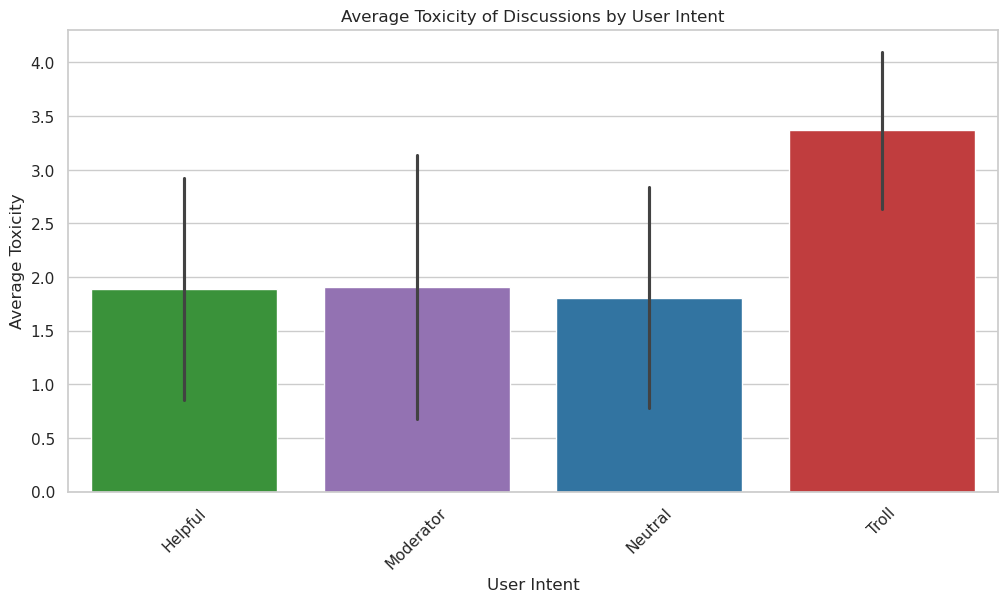

In [7]:
# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="intent",
    hue="intent",
    y="annotation",
    order=USER_INTENT_ORDER,
    errorbar="sd",
    palette=INTENT_PALETTE,
    legend=False,
)

# Customize the plot
plt.title("Average Toxicity of Discussions by User Intent")
plt.xlabel("User Intent")
plt.ylabel("Average Toxicity")
plt.xticks(rotation=45)
plt.show()

### Progression of toxicity

In [8]:
timeseries_df = df.reset_index()
timeseries_df = timeseries_df.drop_duplicates(subset=["conv_id", "user", "message"])

# remove moderator
timeseries_df = timeseries_df[~(timeseries_df.user == "moderator")]

timeseries_df["message_order"] = timeseries_df.groupby("conv_id").cumcount()
timeseries_df.message_order = timeseries_df.message_order + 1  # start from 1

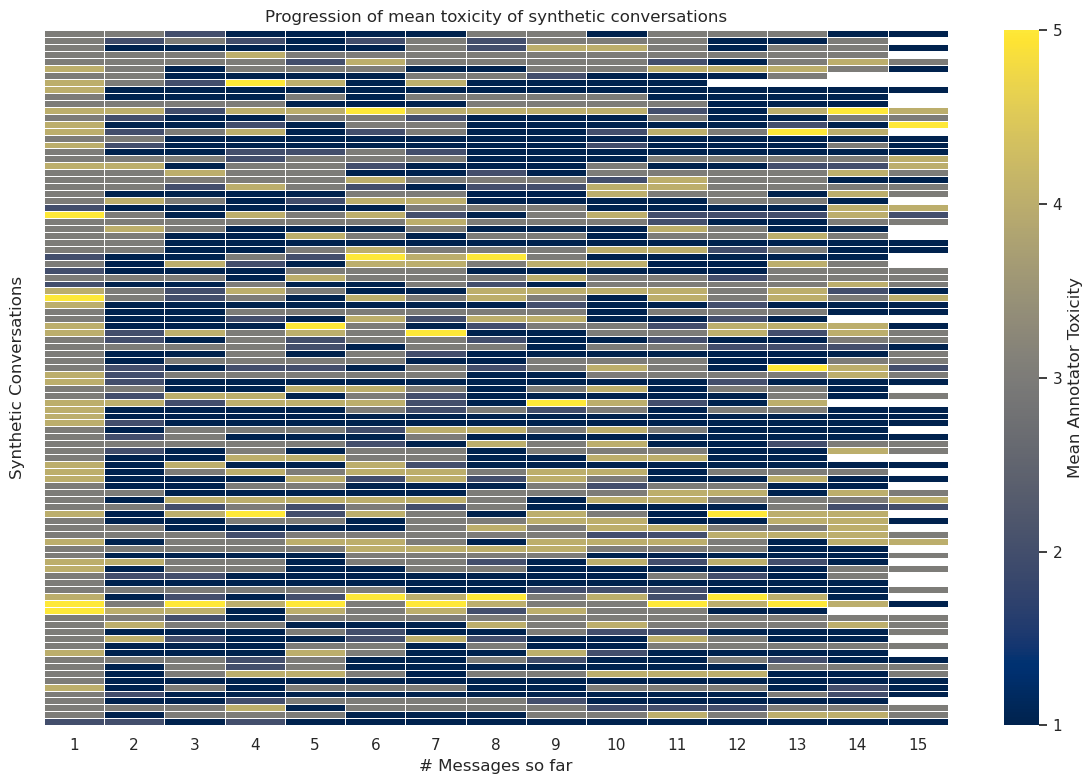

In [24]:
# Calculate the mean toxicity for each message order and conversation
mean_toxicity = (
    timeseries_df.groupby(["conv_id", "message_order"])["annotation"].mean().reset_index()
)

# Pivot the data to create a matrix where rows are conv_id, columns are message_order
heatmap_data = timeseries_df.pivot(
    index="conv_id", columns="message_order", values="annotation"
)

# Create the heatmap plot
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    data=heatmap_data,
    cmap="cividis",
    cbar_kws={"label": "Mean Annotator Toxicity", "ticks": TOXICITY_TICKS},
    linewidths=0.5,
)
ax.set(yticklabels=[])
ax.grid(False)

plt.title("Progression of mean toxicity of synthetic conversations")
plt.xlabel("# Messages so far")
plt.ylabel("Synthetic Conversations")
plt.tight_layout()
plt.show()

### Moderator impact

In [10]:
# Create two subsets: one where moderator_exists is True and one where it's False

with_moderator = timeseries_df[timeseries_df["moderator_exists"] == True]
without_moderator = timeseries_df[timeseries_df["moderator_exists"] == False]

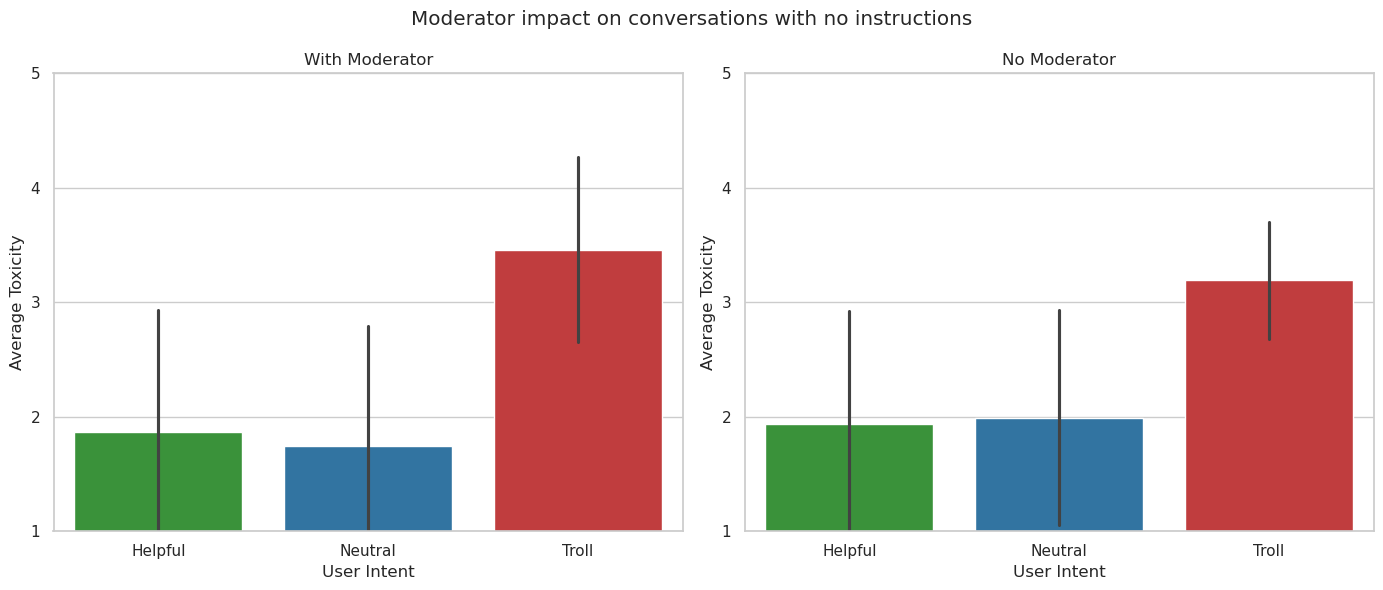

In [19]:
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for conversations with a moderator
sns.barplot(
    data=with_moderator,
    x="intent",
    hue="intent",
    y="annotation",
    order=USER_INTENT_ORDER_NO_MOD,
    errorbar="sd",
    palette=INTENT_PALETTE,
    ax=axes[0],  # Assign plot to first subplot (left)
    legend=False,
)
axes[0].set_title("With Moderator")
axes[0].set_xlabel("User Intent")
axes[0].set_ylabel("Average Toxicity")
axes[0].set_ylim(1,5)
axes[0].set_yticks(TOXICITY_TICKS)

# Plot for conversations without a moderator
sns.barplot(
    data=without_moderator,
    x="intent",
    hue="intent",
    y="annotation",
    order=USER_INTENT_ORDER_NO_MOD,
    errorbar="sd",
    palette=INTENT_PALETTE,
    ax=axes[1],  # Assign plot to second subplot (right)
    legend=False,
)
axes[1].set_title("No Moderator")
axes[1].set_xlabel("User Intent")
axes[1].set_ylabel("Average Toxicity")
axes[1].set_ylim(1,5)
axes[1].set_yticks(TOXICITY_TICKS)
fig.suptitle("Moderator impact on conversations with no instructions")

# Adjust layout for better display
plt.tight_layout()
plt.show()

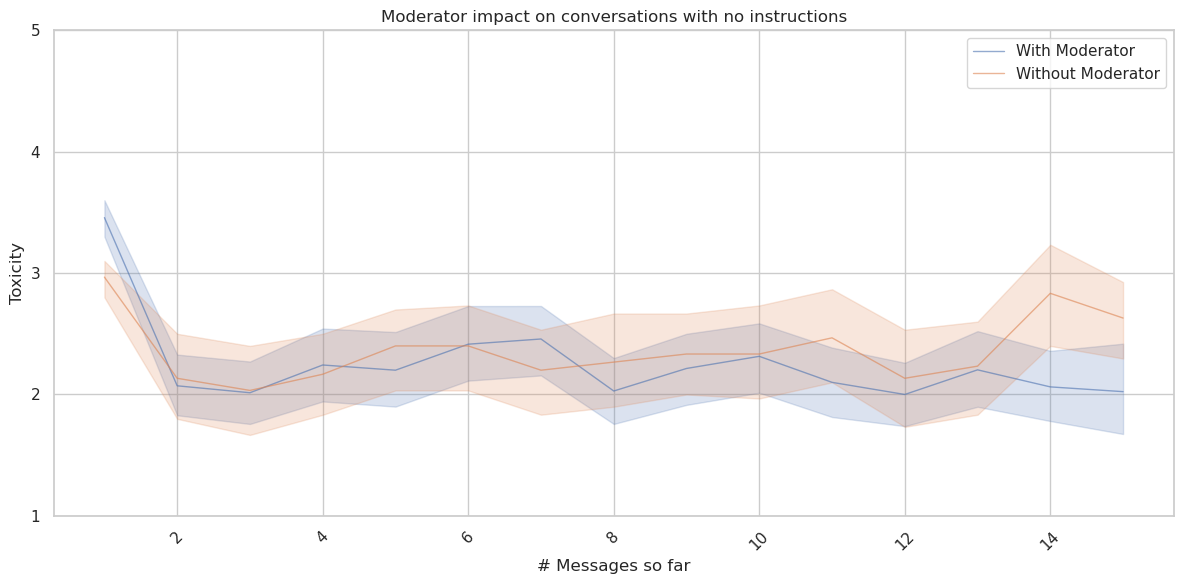

In [12]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot for conversations with a moderator
sns.lineplot(
    data=with_moderator,
    x="message_order",
    y="annotation",
    label="With Moderator",
    lw=1,
    alpha=0.6,
)

# Plot for conversations without a moderator
sns.lineplot(
    data=without_moderator,
    x="message_order",
    y="annotation",
    label="Without Moderator",
    lw=1,
    alpha=0.6,
)

# Customize the plot
plt.title("Moderator impact on conversations with no instructions")
plt.xlabel("# Messages so far")
plt.ylabel("Toxicity")
plt.xticks(rotation=45)
plt.yticks(TOXICITY_TICKS)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_81051/1648901901.py:7: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(


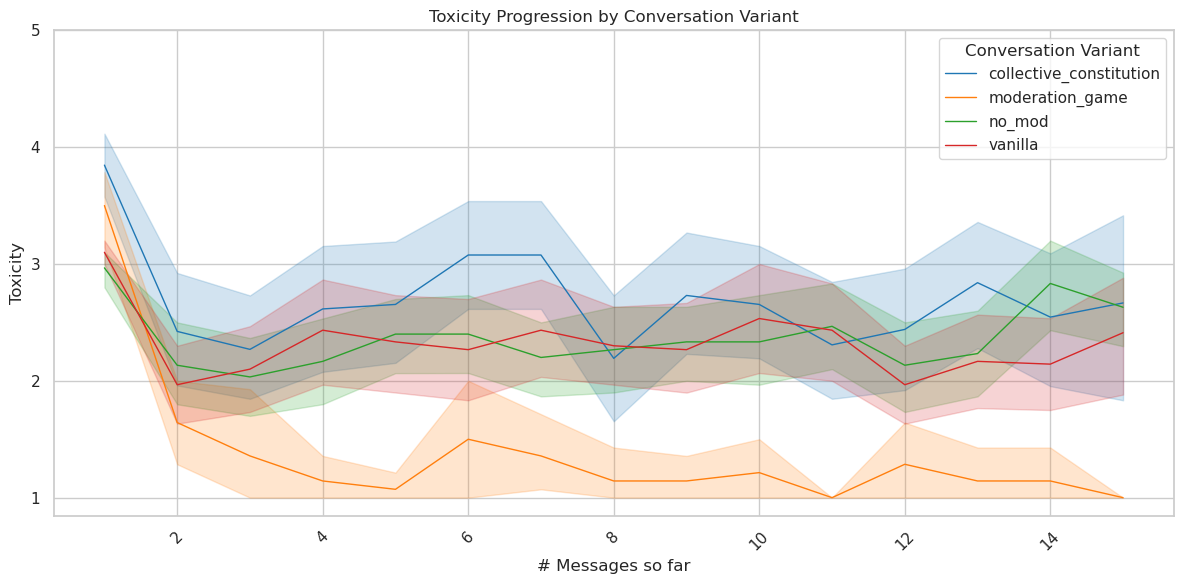

In [13]:
from matplotlib.colors import ListedColormap

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each conversation variant as a separate line
sns.lineplot(
    data=timeseries_df,
    x="message_order", 
    y="annotation", 
    hue="conv_variant",  # Different lines for each variant
    palette=sns.color_palette("tab10"),
    lw=1, 
    alpha=1
)

plt.title("Toxicity Progression by Conversation Variant")
plt.xlabel("# Messages so far")
plt.ylabel("Toxicity")
plt.xticks(rotation=45)
plt.yticks(TOXICITY_TICKS)
plt.legend(title="Conversation Variant")
plt.tight_layout()
plt.show()


/tmp/ipykernel_81051/1586986737.py:7: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(


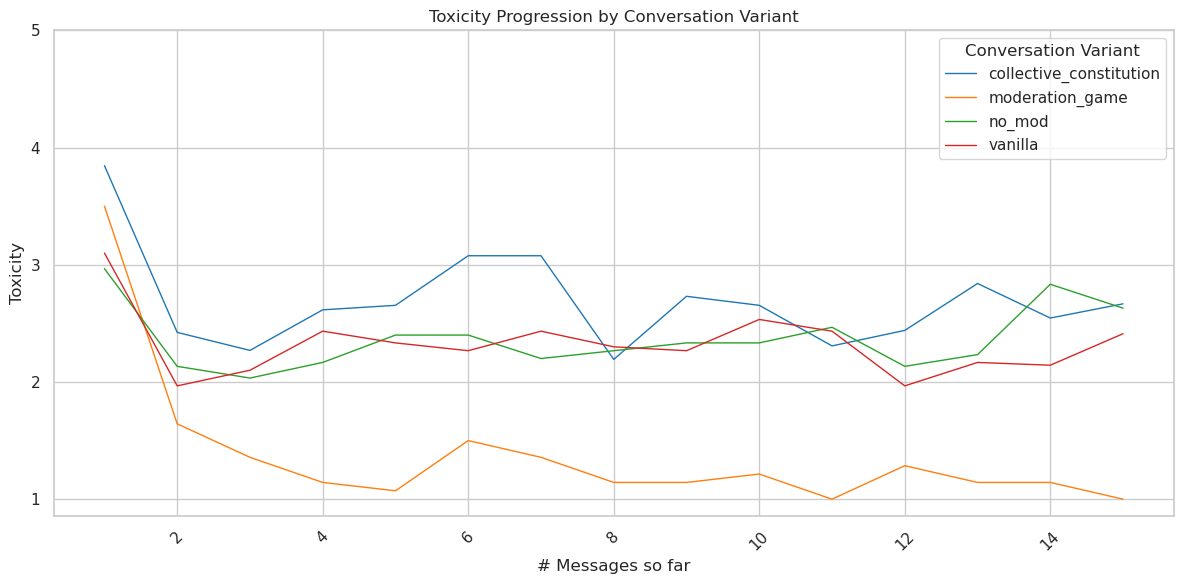

In [22]:
from matplotlib.colors import ListedColormap

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each conversation variant as a separate line
sns.lineplot(
    data=timeseries_df,
    x="message_order", 
    y="annotation", 
    hue="conv_variant",  # Different lines for each variant
    palette=sns.color_palette("tab10"),
    lw=1, 
    alpha=1,
    errorbar=None
)

plt.title("Toxicity Progression by Conversation Variant")
plt.xlabel("# Messages so far")
plt.ylabel("Toxicity")
plt.xticks(rotation=45)
plt.yticks(TOXICITY_TICKS)
plt.legend(title="Conversation Variant")
plt.tight_layout()
plt.show()
